In [37]:
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import os
import sys
import itertools
import datetime
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision.utils import save_image, make_grid
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter


# Chargement des datasets MNIST et SVHN

In [38]:
batch_size = 128

transform_mnist = transforms.Compose([
                transforms.Resize(32),
                transforms.ToTensor(),
                transforms.Normalize((0.5), (0.5))])

transform_svhn = transforms.Compose([
                transforms.Resize(32),
                transforms.ToTensor(),
                transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

mnist_train = datasets.MNIST(root='./mnist', train=True, download=True, transform=transform_mnist)
mnist_test = datasets.MNIST(root='./mnist', train=False, download=True, transform=transform_mnist)

svhn_train = datasets.SVHN(root='./svhn', split='train', download=True, transform=transform_svhn)
svhn_test = datasets.SVHN(root='./svhn', split='test', download=True, transform=transform_svhn)

mnist_train_loader = DataLoader(dataset=mnist_train, batch_size=batch_size, shuffle=True, drop_last=True)
mnist_test_loader = DataLoader(dataset=mnist_test, batch_size=batch_size, shuffle=False, drop_last=True)

svhn_train_loader = DataLoader(dataset=svhn_train, batch_size=batch_size, shuffle=True, drop_last=True)
svhn_test_loader = DataLoader(dataset=svhn_test, batch_size=batch_size, shuffle=False, drop_last=True)

Using downloaded and verified file: ./svhn/train_32x32.mat
Using downloaded and verified file: ./svhn/test_32x32.mat


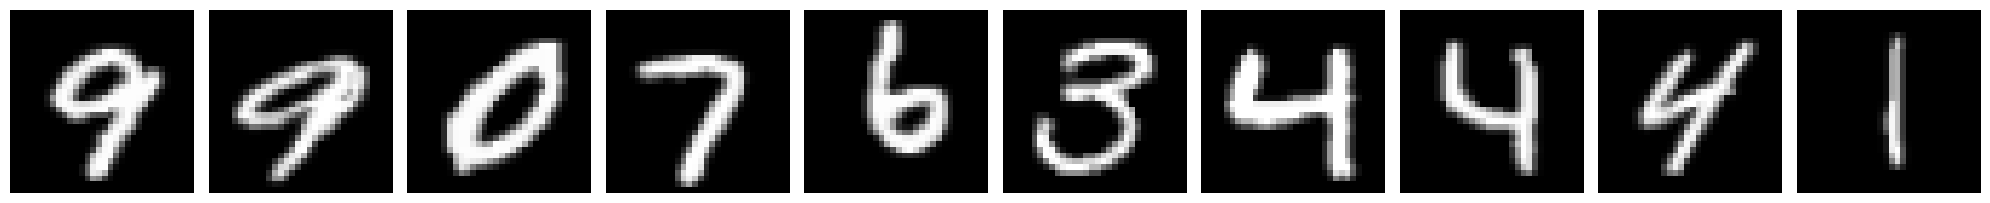

In [39]:
imgs, _ = next(iter(mnist_train_loader))
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = imgs[i].permute(1, 2, 0)
    ax.imshow(img, cmap='gray')
    ax.axis('off')
plt.tight_layout()

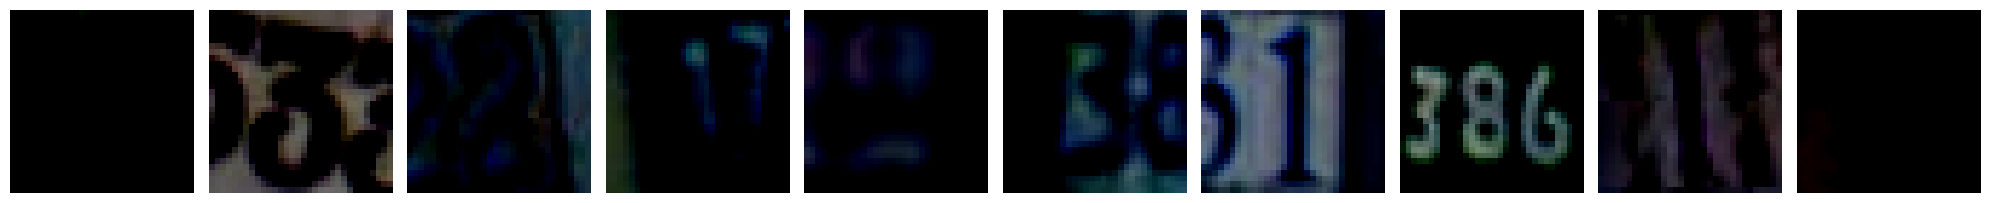

In [40]:
imgs, _ = next(iter(svhn_train_loader))
plt.figure(figsize=(20, 4))
for i in range(10):
    ax = plt.subplot(1, 10, i + 1)
    img = imgs[i].permute(1, 2, 0)
    ax.imshow(img)
    ax.axis('off')
plt.tight_layout()

# Architecture du CycleGan

In [41]:
##############################
#           Generator
##############################
class ResidualBlock(nn.Module):
    def __init__(self, in_features):
        super(ResidualBlock, self).__init__()

        self.block = nn.Sequential(
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3, stride=1, padding=0),
            nn.InstanceNorm2d(in_features),
            nn.ReLU(inplace=True),
            nn.ReflectionPad2d(1),
            nn.Conv2d(in_features, in_features, 3, stride=1, padding=0),
            nn.InstanceNorm2d(in_features)
        )

    def forward(self, x):
        return x + self.block(x)


class GeneratorResNet(nn.Module):
    def __init__(self, input_shape, num_residual_blocks, output_channels):
        super(GeneratorResNet, self).__init__()
        input_channels = input_shape[0]

        # Initial convolution block
        out_features = 64
        model = [
            nn.ReflectionPad2d(3),
            nn.Conv2d(input_channels, out_features, 7, stride=1, padding=0),
            nn.InstanceNorm2d(out_features),
            nn.ReLU(inplace=True),
        ]
        in_features = out_features

        # Downsampling
        for _ in range(2):
            out_features *= 2
            model += [
                nn.Conv2d(in_features, out_features, 3, stride=2, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        # Residual blocks
        for _ in range(num_residual_blocks):
            model += [ResidualBlock(out_features)]

        # Upsampling
        for _ in range(2):
            out_features //= 2
            model += [
                nn.Upsample(scale_factor=2),
                nn.Conv2d(in_features, out_features, 3, stride=1, padding=1),
                nn.InstanceNorm2d(out_features),
                nn.ReLU(inplace=True),
            ]
            in_features = out_features

        model += [
            nn.ReflectionPad2d(3),
            nn.Conv2d(out_features, output_channels, 7, stride=1, padding=0),
            nn.Tanh()
        ]

        self.model = nn.Sequential(*model)

    def forward(self, x):
        return self.model(x)


##############################
#        Discriminator
##############################
class Discriminator(nn.Module):
    def __init__(self, input_shape):
        super(Discriminator, self).__init__()

        channels, _, _ = input_shape

        # Output shape of image discriminator (PatchGAN)
        # Hardcoded here, because we're working with fixed size images (32x32) as input
        # and we thus know the output shape
        self.output_shape = (1, 2, 2)

        def discriminator_block(in_filters, out_filters, stride=2, normalize=True):
            """Returns downsampling layers of each discriminator block"""
            layers = [nn.Conv2d(in_filters, out_filters, 4, stride=stride, padding=1)]
            if normalize:
                layers.append(nn.InstanceNorm2d(out_filters))
            layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *discriminator_block(channels, 64, normalize=False),
            *discriminator_block(64, 128),
            *discriminator_block(128, 256),
            *discriminator_block(256, 512, stride=1),
            nn.Conv2d(512, 1, 4, stride=1, padding=1)
        )

    def forward(self, img):
        return self.model(img)

## Architecture du Classifier : LeNet

In [42]:
##############################
#           Classifier
##############################

class LeNet(nn.Module):
    def __init__(self, input_nc):
        super(LeNet, self).__init__()

        sequence = [
            nn.Conv2d(input_nc, 20, kernel_size=5, stride=1, padding=0),
            nn.MaxPool2d(2, 2),
            nn.ReLU(True),

            nn.Conv2d(20, 50, kernel_size=5, stride=1, padding=0),
            nn.Dropout2d(0.5),
            nn.MaxPool2d(2, 2),
            nn.ReLU(True),

            nn.Flatten(),

            nn.Linear(50*5*5, 500),
            nn.ReLU(True),
            nn.Dropout(0.5),

            nn.Linear(500, 10)
        ]
        self.net = nn.Sequential(*sequence)

    def forward(self, input):
        """Standard forward."""
        self.out = self.net(input)
        return self.out

### Fonctions Utiles

In [43]:
def checkpoint(G_MNIST_SVHN, G_SVHN_MNIST, D_SVHN, D_MNIST, epoch):
    """Saves the parameters of both generators and discriminators.
    """
    model_directory = 'saved_models'
    os.makedirs(model_directory, exist_ok=True)

    torch.save(G_MNIST_SVHN.state_dict(), "saved_models/G_MNIST_SVHN_epoch_%d.pth" % epoch)
    torch.save(G_SVHN_MNIST.state_dict(), "saved_models/G_SVHN_MNIST_epoch_%d.pth" % epoch)
    torch.save(D_SVHN.state_dict(), "saved_models/D_SVHN_epoch_%d.pth" % epoch)
    torch.save(D_MNIST.state_dict(), "saved_models/D_MNIST_epoch_%d.pth" % epoch)


def sample_images(G_MNIST_SVHN, G_SVHN_MNIST, fixed_MNIST, fixed_SVHN, epoch):
    """Saves a generated sample from the test set"""
    image_directory = 'images'
    os.makedirs(image_directory, exist_ok=True)

    G_MNIST_SVHN.eval()
    G_SVHN_MNIST.eval()

    # Generate images (translation and cycle)
    fake_MNIST = G_SVHN_MNIST(fixed_SVHN)
    fake_SVHN = G_MNIST_SVHN(fixed_MNIST)

    recov_MNIST = G_SVHN_MNIST(fake_SVHN)
    recov_SVHN = G_MNIST_SVHN(fake_MNIST)

    # Arange images along x-axis
    real_MNIST_grid = make_grid(fixed_MNIST, nrow=20, normalize=True)
    real_SVHN_grid = make_grid(fixed_SVHN, nrow=20, normalize=True)
    fake_SVHN_grid = make_grid(fake_SVHN, nrow=20, normalize=True)
    fake_MNIST_grid = make_grid(fake_MNIST, nrow=20, normalize=True)
    recov_MNIST_grid = make_grid(recov_MNIST, nrow=20, normalize=True)
    recov_SVHN_grid = make_grid(recov_SVHN, nrow=20, normalize=True)

    # Arange images along y-axis
    image_grid = torch.cat((real_MNIST_grid,
                            fake_SVHN_grid,
                            recov_MNIST_grid,
                            real_SVHN_grid,
                            fake_MNIST_grid,
                            recov_SVHN_grid),
                           1)

    save_image(image_grid, "images/epoch_%s.png" % epoch, normalize=False)


def eval_model_and_show_examples(model, criterion, dataloader, device, generator, num_examples=10):
    model.eval()
    total = 0
    correct = 0
    examples = 0

    fig, axes = plt.subplots(1, num_examples, figsize=(15, 3))

    with torch.no_grad():
        for data in dataloader:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            # Transform MNIST images to SVHN style using the generator
            if generator is not None:
                transformed_images = generator(images)
            outputs = model(transformed_images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

            if examples < num_examples:
                for idx in range(images.size(0)):
                    if examples >= num_examples:
                        break
                    ax = axes[examples]
                    ax.imshow(transformed_images[idx].cpu().permute(1, 2, 0) * 0.5 + 0.5)  # unnormalize
                    ax.set_title(f'Pred: {predicted[idx].item()}\nTrue: {labels[idx].item()}')
                    ax.axis('off')
                    examples += 1

    accuracy = 100 * correct / total
    plt.show()
    return accuracy

def weights_init_normal(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight.data, 0.0, 0.02)
        if hasattr(m, "bias") and m.bias is not None:
            torch.nn.init.constant_(m.bias.data, 0.0)
    elif classname.find("BatchNorm2d") != -1:
        torch.nn.init.normal_(m.weight.data, 1.0, 0.02)
        torch.nn.init.constant_(m.bias.data, 0.0)

## Paramètrage

In [44]:
class Options:
    def __init__(self):
        self.n_epochs = 10              # Insérez le nombre d'époques souhaité
        self.batch_size = 128           # Taille du lot
        self.lr = 0.0002                # Taux d'apprentissage pour l'optimiseur Adam
        self.b1 = 0.5                   # Coefficient de dégradation du momentum de premier ordre
        self.b2 = 0.999                 # Coefficient de dégradation du momentum de deuxième ordre
        self.n_residual_blocks = 9      # Nombre de blocs résiduels dans le générateur
        self.lambda_cyc = 10.0          # Poids de la perte de cycle-consistence
        self.tensorboard_path = './runs/default' # Chemin pour les logs Tensorboard

opts = Options()

## Entrainement du modèle

In [45]:
def training_loop(MNIST_dataloader, SVHN_dataloader, MNIST_test_dataloader, SVHN_test_dataloader, opts):
    # Device configuration
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    # Losses
    criterion_GAN = torch.nn.MSELoss()
    criterion_cycle = torch.nn.L1Loss()
    criterion_classifier = torch.nn.CrossEntropyLoss()  # For LeNet classifier

    # Initialize CycleGAN models
    G_MNIST_SVHN = GeneratorResNet((1, 32, 32), opts.n_residual_blocks, 3).apply(weights_init_normal).to(device)
    G_SVHN_MNIST = GeneratorResNet((3, 32, 32), opts.n_residual_blocks, 1).apply(weights_init_normal).to(device)
    D_MNIST = Discriminator((1, 32, 32)).apply(weights_init_normal).to(device)
    D_SVHN = Discriminator((3, 32, 32)).apply(weights_init_normal).to(device)

    # Initialize LeNet classifier
    classifier = LeNet(input_nc=3).to(device)

    # Optimizers for GAN and classifier
    optimizer_G = optim.Adamax(itertools.chain(G_MNIST_SVHN.parameters(), G_SVHN_MNIST.parameters()), lr=opts.lr, betas=(opts.b1, opts.b2))
    optimizer_D_MNIST = optim.Adamax(D_MNIST.parameters(), lr=opts.lr, betas=(opts.b1, opts.b2))
    optimizer_D_SVHN = optim.Adamax(D_SVHN.parameters(), lr=opts.lr, betas=(opts.b1, opts.b2))
    optimizer_classifier = optim.Adamax(classifier.parameters(), lr=0.0001, betas=(0.5, 0.999))

    # Fixed images for generating test samples
    fixed_MNIST, _ = next(iter(MNIST_test_dataloader))
    fixed_SVHN, _ = next(iter(SVHN_test_dataloader))
    fixed_MNIST = fixed_MNIST.to(device)[:20]
    fixed_SVHN = fixed_SVHN.to(device)[:20]

    # TensorBoard setup
    writer = SummaryWriter(opts.tensorboard_path)
    prev_time = time.time()

    # Initialize loss storage
    D_losses = []
    G_losses = []
    classifier_losses = []

    # Main training loop
    for epoch in range(1, opts.n_epochs+1):
        total = 0
        correct = 0
        epoch_D_losses = []
        epoch_G_losses = []
        epoch_classifier_losses = []

        iter_MNIST = iter(MNIST_dataloader)
        iter_SVHN = iter(SVHN_dataloader)

        iter_per_epoch = min(len(iter_MNIST), len(iter_SVHN))

        for i in range(iter_per_epoch):
            # Current batch
            MNIST_imgs, MNIST_labels = next(iter_MNIST)
            SVHN_imgs, SVHN_labels = next(iter_SVHN)

            MNIST_imgs = MNIST_imgs.to(device)
            SVHN_imgs = SVHN_imgs.to(device)

            # Adversarial ground truths
            valid = torch.tensor(np.ones((MNIST_imgs.size(0), *D_MNIST.output_shape)), requires_grad=False, dtype=torch.float32).to(device)
            fake = torch.tensor(np.zeros((MNIST_imgs.size(0), *D_MNIST.output_shape)), requires_grad=False, dtype=torch.float32).to(device)

            G_MNIST_SVHN.train()
            G_SVHN_MNIST.train()

            # ----------------------------
            #  Train Discriminator (MNIST)
            # ----------------------------

            optimizer_D_MNIST.zero_grad()

            D_MNIST_loss_real = criterion_GAN(D_MNIST(MNIST_imgs), valid)
            fake_MNIST = G_SVHN_MNIST(SVHN_imgs)
            D_MNIST_loss_fake = criterion_GAN(D_MNIST(fake_MNIST), fake)
            D_MNIST_loss = (D_MNIST_loss_real + D_MNIST_loss_fake) / 2

            D_MNIST_loss.backward()
            optimizer_D_MNIST.step()

            # ----------------------------
            #  Train Discriminator (SVHN)
            # ----------------------------

            optimizer_D_SVHN.zero_grad()

            D_SVHN_loss_real = criterion_GAN(D_SVHN(SVHN_imgs), valid)
            fake_SVHN = G_MNIST_SVHN(MNIST_imgs)
            D_SVHN_loss_fake = criterion_GAN(D_SVHN(fake_SVHN), fake)
            D_SVHN_loss = (D_SVHN_loss_real + D_SVHN_loss_fake) / 2

            D_SVHN_loss.backward()
            optimizer_D_SVHN.step()

            # Total Discriminator loss
            D_loss = (D_MNIST_loss + D_SVHN_loss) / 2

            # -----------------------
            #  Train Generators
            # -----------------------

            optimizer_G.zero_grad()

            # Regenerate fake images for generator training
            fake_MNIST = G_SVHN_MNIST(SVHN_imgs)
            fake_SVHN = G_MNIST_SVHN(MNIST_imgs)

            # GAN loss
            SVHN_MNIST_GAN_loss = criterion_GAN(D_MNIST(fake_MNIST), valid)
            MNIST_SVHN_GAN_loss = criterion_GAN(D_SVHN(fake_SVHN), valid)

            G_GAN_loss = (SVHN_MNIST_GAN_loss + MNIST_SVHN_GAN_loss) / 2

            # Cycle loss
            recov_MNIST = G_SVHN_MNIST(fake_SVHN)
            MNIST_cycle_loss = criterion_cycle(recov_MNIST, MNIST_imgs)

            recov_SVHN = G_MNIST_SVHN(fake_MNIST)
            SVHN_cycle_loss = criterion_cycle(recov_SVHN, SVHN_imgs)

            G_cycle_loss = (MNIST_cycle_loss + SVHN_cycle_loss) / 2

            # Total generator loss
            G_loss = G_GAN_loss + opts.lambda_cyc * G_cycle_loss

            G_loss.backward()
            optimizer_G.step()

            # After updating generators, use the MNIST-to-SVHN generator to create images for classifier training
            transformed_MNIST = G_MNIST_SVHN(MNIST_imgs)
            MNIST_labels = MNIST_labels.to(device)

            # Train classifier with transformed images and MNIST labels
            optimizer_classifier.zero_grad()
            classifier_predictions = classifier(transformed_MNIST)
            loss_classifier = criterion_classifier(classifier_predictions, MNIST_labels)
            loss_classifier.backward()
            optimizer_classifier.step()

            # Calculate accuracy
            _, predicted = torch.max(classifier_predictions.data, 1)
            total += MNIST_labels.size(0)
            correct += (predicted == MNIST_labels).sum().item()

            # Store losses
            epoch_D_losses.append(D_loss.item())
            epoch_G_losses.append(G_loss.item())
            epoch_classifier_losses.append(loss_classifier.item())


            # --------------
            #  Log Progress
            # --------------

            # Print log
            if i % 50 == 0:
                sys.stdout.write(
                    "\r[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f, adv: %f, cycle: %f]"
                    % (
                        epoch,
                        opts.n_epochs,
                        i,
                        iter_per_epoch,
                        D_loss.item(),
                        G_loss.item(),
                        G_GAN_loss.item(),
                        G_cycle_loss.item()
                    )
                )

                writer.add_scalar('Loss/Discriminator', D_loss, (epoch-1)*iter_per_epoch + i)
                writer.add_scalar('Loss/D_MNIST', D_MNIST_loss, (epoch - 1) * iter_per_epoch + i)
                writer.add_scalar('Loss/D_SVHN', D_SVHN_loss, (epoch - 1) * iter_per_epoch + i)
                writer.add_scalar('Loss/Generator', G_loss, (epoch-1)*iter_per_epoch + i)
                writer.add_scalar('Loss/Generator_GAN', G_GAN_loss, (epoch-1)*iter_per_epoch + i)
                writer.add_scalar('Loss/G_SVHN_MNIST_GAN', SVHN_MNIST_GAN_loss, (epoch - 1) * iter_per_epoch + i)
                writer.add_scalar('Loss/G_MNIST_SVHN_GAN', MNIST_SVHN_GAN_loss, (epoch - 1) * iter_per_epoch + i)
                writer.add_scalar('Loss/Generator_Cycle', G_cycle_loss, (epoch-1)*iter_per_epoch + i)
                writer.add_scalar('Loss/MNIST_cycle_loss', MNIST_cycle_loss, (epoch - 1) * iter_per_epoch + i)
                writer.add_scalar('Loss/SVHN_cycle_loss', SVHN_cycle_loss, (epoch - 1) * iter_per_epoch + i)

        # Average losses for each epoch and store
        D_losses.append(sum(epoch_D_losses) / len(epoch_D_losses))
        G_losses.append(sum(epoch_G_losses) / len(epoch_G_losses))
        classifier_losses.append(sum(epoch_classifier_losses) / len(epoch_classifier_losses))

        # Logging the accuracy
        epoch_accuracy = 100 * correct / total
        print(f' Epoch {epoch} Accuracy: {epoch_accuracy:.2f}%')

        # Save the generated samples
        sample_images(G_MNIST_SVHN, G_SVHN_MNIST, fixed_MNIST, fixed_SVHN, epoch)

        # Save model weights
        checkpoint(G_MNIST_SVHN, G_SVHN_MNIST, D_SVHN, D_MNIST, epoch)

    test_accuracy = eval_model_and_show_examples(classifier, criterion_classifier, MNIST_test_dataloader, device, G_MNIST_SVHN, num_examples=10)
    print(f'Test Accuracy: {test_accuracy:.2f}%')
    return D_losses, G_losses, classifier_losses

[Epoch 1/10] [Batch 450/468] [D loss: 0.197252] [G loss: 2.573078, adv: 0.681927, cycle: 0.189115] Epoch 1 Accuracy: 41.34%
[Epoch 2/10] [Batch 450/468] [D loss: 0.234888] [G loss: 2.282645, adv: 0.526365, cycle: 0.175628] Epoch 2 Accuracy: 63.92%
[Epoch 3/10] [Batch 450/468] [D loss: 0.164917] [G loss: 2.131196, adv: 0.609094, cycle: 0.152210] Epoch 3 Accuracy: 67.66%
[Epoch 4/10] [Batch 450/468] [D loss: 0.195185] [G loss: 2.039654, adv: 0.503505, cycle: 0.153615] Epoch 4 Accuracy: 71.05%
[Epoch 5/10] [Batch 450/468] [D loss: 0.155377] [G loss: 2.199360, adv: 0.677906, cycle: 0.152145] Epoch 5 Accuracy: 71.30%
[Epoch 6/10] [Batch 450/468] [D loss: 0.143068] [G loss: 2.226982, adv: 0.767407, cycle: 0.145957] Epoch 6 Accuracy: 74.12%
[Epoch 7/10] [Batch 450/468] [D loss: 0.140668] [G loss: 1.988365, adv: 0.619535, cycle: 0.136883] Epoch 7 Accuracy: 74.33%
[Epoch 8/10] [Batch 450/468] [D loss: 0.210368] [G loss: 1.958497, adv: 0.693716, cycle: 0.126478] Epoch 8 Accuracy: 75.83%
[Epoch 9

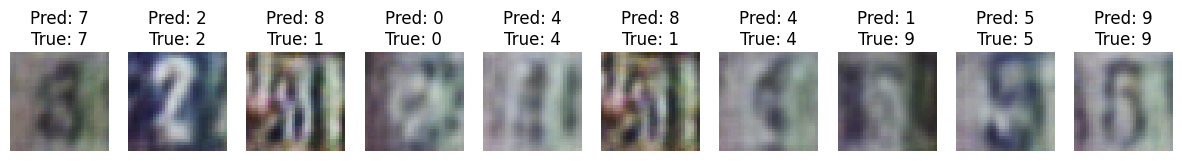

Test Accuracy: 84.08%


In [46]:
D_losses, G_losses, classifier_losses = training_loop(mnist_train_loader, svhn_train_loader, mnist_test_loader, svhn_test_loader, opts)

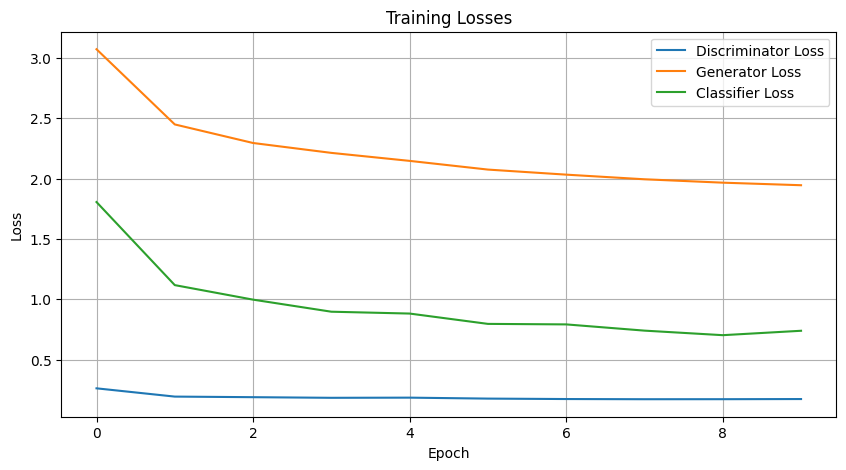

In [47]:
import matplotlib.pyplot as plt

def plot_losses(D_losses, G_losses, classifier_losses):
    plt.figure(figsize=(10, 5))
    plt.plot(D_losses, label='Discriminator Loss')
    plt.plot(G_losses, label='Generator Loss')
    plt.plot(classifier_losses, label='Classifier Loss')
    plt.title('Training Losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)
    plt.show()

plot_losses(D_losses, G_losses, classifier_losses)